Getting Satellite images and Terrain maps
-----------------------------------------------------------

Go to [Google cloud console](https://console.cloud.google.com/marketplace/details/google/static-maps-backend.googleapis.com?) and activate your static map API.
Store your API key in a file somewhere safe and accessible, we will need it.

In [1]:
import requests

In [2]:
def get_api_key():
    with open('/home/gokul/.api_keys/static_gmaps.key') as rfile:
        return rfile.readline()[:-1]

In [3]:
api_key = get_api_key()

Check out [Google Maps API Reference](https://developers.google.com/maps/documentation/maps-static/dev-guide)

In [4]:
def get_static_map(lat=40.714738, long=-73.998693, zoom=12,
                   size=512, maptype='terrain', labels=False):
    
    url = "https://maps.google.com/maps/api/staticmap?"
    # url += "sensor=false&"
    url += f"size={size}x{size}&"
    url += f"center={lat},{long}&"
    url += f"zoom={zoom}&"
    url += f"maptype={maptype}&"
    if not labels:
        url += "style=feature:all|element:labels|visibility:off&"
    url += f"key={api_key}"
    data = requests.get(url)
    return data.content

In [5]:
def save_image(data, fname):
    with open(fname, 'wb') as wfile:
        wfile.write(data)

Let's get some idea which zoom level and maptype will be suitable for our purpose

In [6]:
for m in ['terrain', 'satellite', 'roadmap', 'hybrid']:
    for z in range(12, 19):
        save_image(get_static_map(zoom=z, maptype=m),
                   'checking/' + str(z) + '/' + m + str(z) + '.png')

Looking manually through map images all the zoom levels generated above, I choose to work with zoom level 16

Input Map
----------------

<img src="images/satellite16.png" alt="Drawing" style="width: 300px;"/>


Output Map
----------------

<img src="images/terrain16.png" alt="Drawing" style="width: 300px;"/>

Let's check at this zoom level, what is scale of the map we got.

Using Google maps distance measurement tool, the aproximate length cover my the above map is `~ 930 m (3050 ft)`

<img src="images/distance.png" alt="Drawing" style="width: 300px;"/>

Let's suppose we choose a city ex. *San Francisco*, then we could get enough map data by calling the above function n-times with randomly choosen lat-longs inside the city. To make sure that no 2 maps images overlap the same area/land, we need to make sure that the choosen lat-longs are atleast `930 m` away (let's say `1000 m` away for saftey). 

**\# bounding boxes of city**

If we know the bounding boxed of a city, we can divide the whole city into `1000 m` by `1000 m` grids, we could either use all the lat-longs from grid or randomly select some to get the required maps.

**We can randomly generate lat-longs, but how do we know it is inside the city or even worse not in the ocean ?**

I found Geographical boundaries of Bay Area [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Bay-Area-Counties/s9wg-vcph)

<img src="images/counties.png" alt="Drawing" style="width: 300px;"/>

In [7]:
import shapefile
import numpy as np
import matplotlib.pyplot as plt

In [22]:
%matplotlib inline
plt.style.use("ggplot")

In [9]:
sf = shapefile.Reader('SanFrancisco/BayAreaCounties.shp')

In [10]:
len(sf.shapes())

9

This shape file contains 9 Counties

In [24]:
county = sf.shape(3)

Bounding Box for Napa county

In [25]:
county.bbox

[-122.64642100248683, 38.15489399914849, -122.06137900148687, 38.864244998709104]

In [26]:
x_lon = np.array([point[0] for point in county.points])
y_lat = np.array([point[1] for point in county.points])

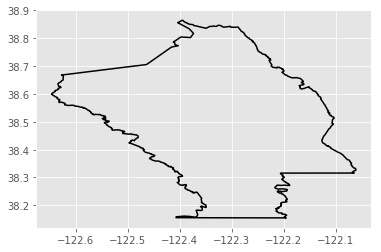

In [27]:
plt.plot(x_lon, y_lat,'k')

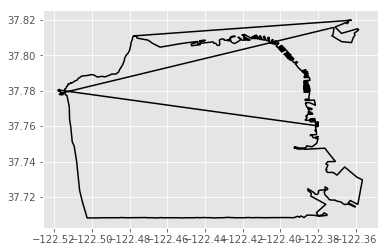

In [28]:
county = sf.shape(4)
x_lon = np.array([point[0] for point in county.points])
y_lat = np.array([point[1] for point in county.points])

# removing the islands
check1 = x_lon >= -122.6
check2 = y_lat <= 37.82
check3 = x_lon <= -122.35
check = check1 & check2 & check3

plt.plot(x_lon[check], y_lat[check],'k')

In [30]:
print(x_lon.min(), x_lon.max())
print(y_lat.min(), y_lat.max())

-123.10802700119842 -122.32768100246903
37.69306499862042 37.863425998396984


We choose **Napa** and **San Francisco** counties as one will be city other will be urban

**Creating a `1000 m` x `1000 m` Grid**

In [31]:
import math
from shapely.geometry import Polygon, Point

Since Earth is sperical the actual disctance between 2 points is not the eucledian distance but the distance across the great-circle joining the 2 points. To do this we need to use somthing called [HaverSine](https://en.wikipedia.org/wiki/Haversine_formula) formulae. 

Ideally we would be implementing [this algorithm](http://www.edwilliams.org/avform.htm#LL) to find a lat-long that is some distance away from the reference at some angle with respect to due north. But since our distance is small we don't have to go through the this hasle. There is this quick and dirty trick mentioned [here](https://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters?rq=1).

In [34]:
def project_lat_long(lat, long, theta, dist):
    
    '''
    function to get new lat-long which is far away from the 
    given lat-long by `dist` [meters] at an `theta` [degrees]
    from the north measured in clockwise direction.
    '''
    lat_to_km = 111_111    # in meters
    
    return 

In [32]:
def is_point_inside_poly(poly_object, search_point):
    return search_point.within(poly_object)

In [ ]:
def make_grids(lat_min, lat_max, long_max, long_min, min_dis=1000):
    